# Application Demo

As of June 25th, 2020, all the application functions are packaged in this toolkit. In the following cells, a sample behaviour is shown, where all the toolkit is put to the test.

## Stage 1: Input & Pre-processing

(Note the starting load)

In [1]:
%%time

from recognition import RecognitionNet, HighlightDetector, StringVectorizer, TextChecker, ColorExtractor, ColorGroup
from preproc import RobustBinarize, Page, Deslanter, SegmentationNetwork
from languages import LanguageTransformer, HTMLMinidownColorListener
from IPython.display import IFrame

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

plt.rcParams['figure.figsize'] = (10, 9)

def to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def imload(fpath):
    return cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB)

Using TensorFlow backend.


Wall time: 4.52 s


Wall time: 3.7 s


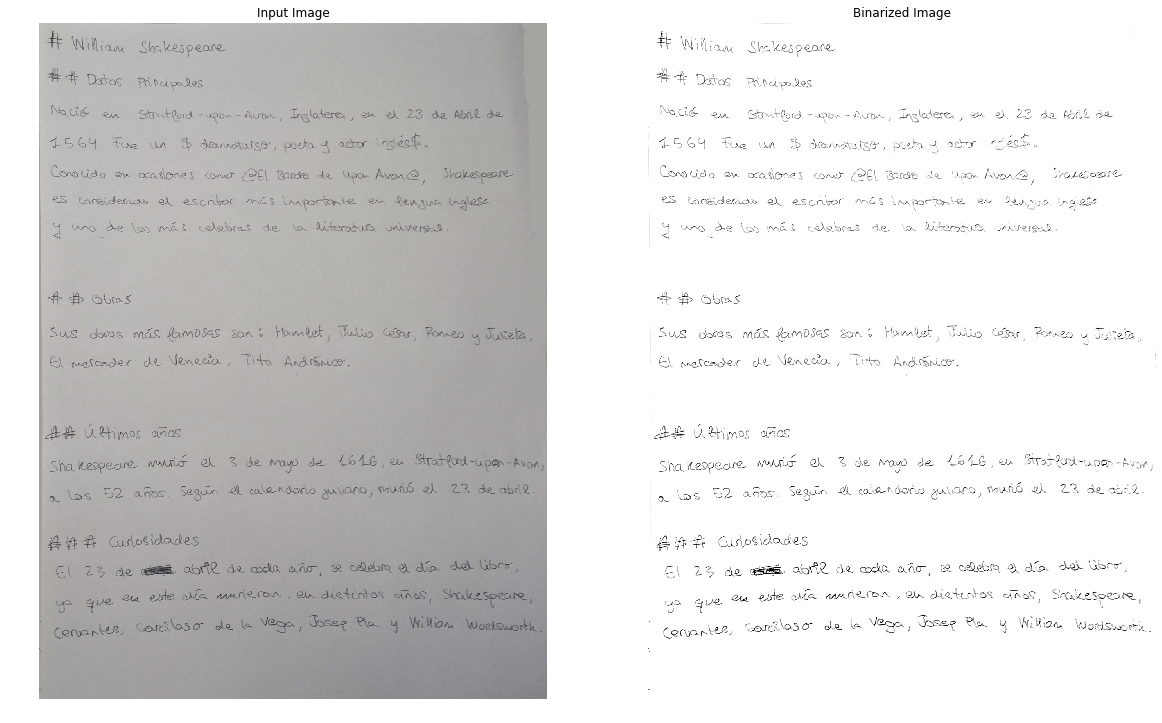

In [2]:
input_image_fpath = "../data-sources/spanish-words-originals/test3.jpg"
input_image = imload(input_image_fpath)

%time bin_image = RobustBinarize.illumination_compensation(input_image)

_, axes = plt.subplots(1,2, figsize=(20,15))

axes[0].imshow(input_image)
axes[0].set_title("Input Image")
axes[0].axis("off")

axes[1].imshow(bin_image, cmap="gray")
axes[1].set_title("Binarized Image")
axes[1].axis("off")
plt.show()

Wall time: 12.4 s


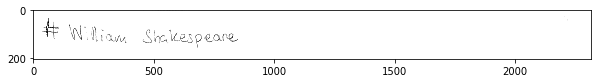

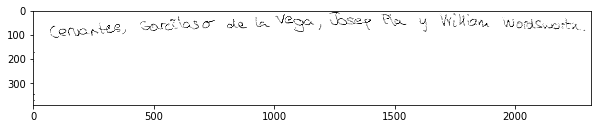

In [4]:
%time lines = Page.get_lines(bin_image)

plt.figure()
plt.imshow(lines[0][0], cmap="gray")
plt.show()

plt.figure()
plt.imshow(lines[-1][0], cmap="gray")
plt.show()

Wall time: 595 ms


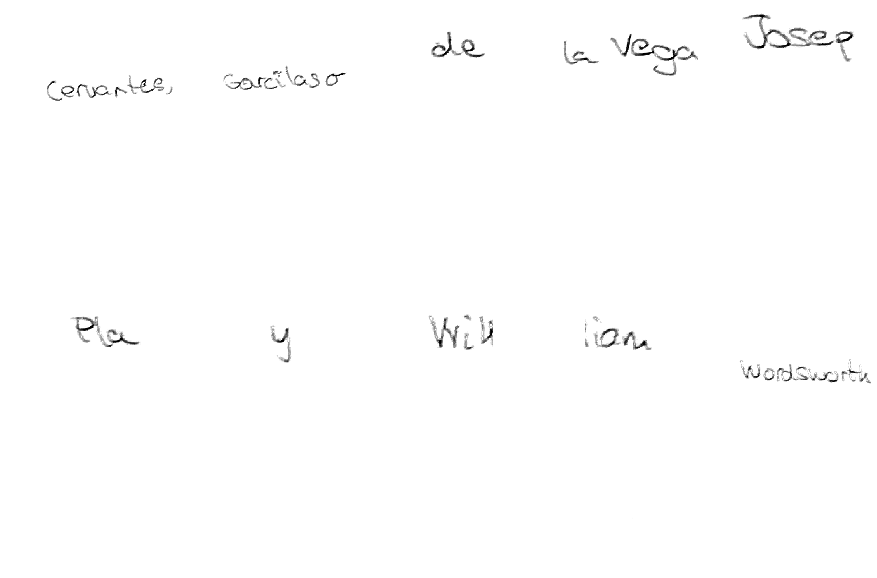

In [5]:
%time words = Page.get_words(lines)

_, axes = plt.subplots(2, len(words[-1]) // 2, figsize=(15,10))
axes = axes.flatten()

for i, (w, _) in enumerate(words[-1]):
    axes[i].imshow(w, cmap="gray")
    axes[i].axis("off")
    
plt.show()

There are a set of features which are not shown here, namely:
  + Paragraph segmentation
  + Word deslanting

## Stage 2: Text Recognition

In [32]:
net = RecognitionNet(".")
net.load_chkpt()

width, height, _ = net.model.layers[0].input_shape[0][1:]
IMAGE_RATIO = width / height

line = ""
proc_words = np.array([RecognitionNet.preprocess(wrd, aspect_ratio=IMAGE_RATIO, target_size=(width, height)) for wrd, _ in words[-1]])

preds, probs = net.predict(proc_words)

vect = StringVectorizer()
for pred_word in preds:
    wrd = vect.decode(pred_word.flatten())
    line += f"{wrd} "

line = line.strip()

In [33]:
print(line)

Cervantes Garciaso de laVega Josp Pla y Will iam Wordsworth


In [34]:
checker = TextChecker([line])
checked_lines = checker.correct()

print(checked_lines)

Cervantes Garcilaso de la Vega Josep Pla y Will iam Wordsworth


In [97]:
checked_words = ["Cervantes", "Garcilaso", "de", "la Vega", "Josep", "Pla", "y", "Will", "iam", "Wordsworth"]

## Stage 3: Color Recognition

In [61]:
net = HighlightDetector()
net.load_model()

height, width, _ = net.model.layers[0].input_shape[1:]

orig_color_words = (input_image[xmin:xmax, ymin:ymax, :] for _, (xmin, ymin, xmax, ymax) in words[-1])
color_words = (cv2.resize(wrd, (height, width), cv2.INTER_CUBIC) for wrd in orig_color_words)
color_words = np.array([HighlightDetector.preprocess(wrd, brightness=20, contrast_gain=.05) for wrd in color_words])

In [68]:
pred_class = [HighlightDetector.decode(prediction) for prediction in net.predict(color_words)]

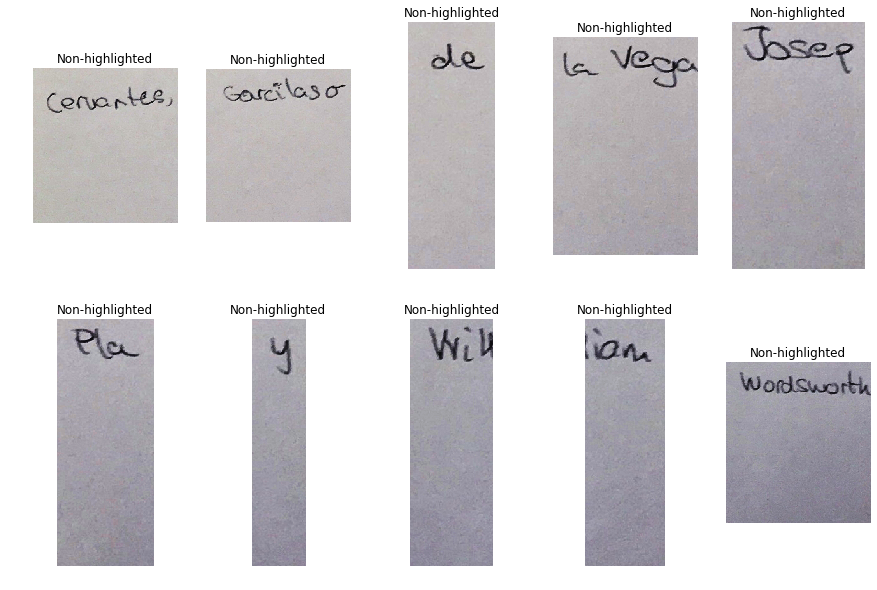

In [91]:
_, axes = plt.subplots(2, len(color_words) // 2, figsize=(15,10))
axes = axes.flatten()

for i, (_word, _class) in enumerate(zip(color_words, pred_class)):
    axes[i].imshow(_word)
    axes[i].set_title(_class)
    axes[i].axis("off")
    
plt.show()

color_words_classes = list(zip(color_words, pred_class))

In [101]:
predictor = ColorGroup()

palettes = (ColorExtractor(word).palette(num_colors=3) for word, _ in color_words_classes)
palettes = [[predictor.predict(color) for color in palette] for palette in palettes]


final_data = []
for _word, _class, _palette in zip(checked_words, pred_class, palettes):
    if _class.lower() == "highlighted":
        color = _palette[0]  # if highlighted, the most predominant color must be the highlight color
    else:
        color = None # if non-highlighted, then add no color at all
    final_data.append((_word, color))

In [102]:
print(final_data)

[('Cervantes', None), ('Garcilaso', None), ('de', None), ('la Vega', None), ('Josep', None), ('Pla', None), ('y', None), ('Will', None), ('iam', None), ('Wordsworth', None)]


## Stage 4: Text Processing

In [12]:
final_text = "(Cervantes , black , None) (Garcilaso , black , None) (de , black , None) (laVega , black , None) (Josep , black , None) (Pla , black , None) (y , black , None) (Will , black , None) (iam , black , None) (Wordsworth , black , None)"

In [105]:
final_text = ""
for (word, color) in final_data:
    final_text += f"({word} , {color}) "
    
final_text = final_text.replace("\'", "")

print(final_text)

(Cervantes, None) (Garcilaso, None) (de, None) (la Vega, None) (Josep, None) (Pla, None) (y, None) (Will, None) (iam, None) (Wordsworth, None) 


In [ ]:
for i in enumerate(lines):
    final_text += f"{} "
    final_text += "\n"

In [13]:
LanguageTransformer(
    listener=HTMLMinidownColorListener,
    text_input=final_text,
    output_fpath="demo.html"
)

In [14]:
IFrame(src='./demo.html', width=700, height=300)